In [462]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [463]:
import sys
sys.path.insert(0, '..//')

import pandas as pd
import numpy as np
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import itertools
import math

sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 2.5)
figsize_map = (16, 8)

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

from src.models import thermal_model, validation
from src.common import functions, enums, schema, sim_param
from src.data import source


In [464]:
path_loughborough_data = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\resources\prediction of overheating data\extra_data_Loughborough')
path_weather_data = path_loughborough_data/'Weather_hourly.csv'
path_IHG_east_dwelling_data = path_loughborough_data/'East_IHG_hourly.csv'
path_save_figures = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\communication\figures')
# path_measured_IAT = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\resources\prediction of overheating data\MeasuredTemperature_16Jun-6Jul_2017.xlsx')
# path_IES_data = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\resources\prediction of overheating data\Loughborough Output.xlsx')
# sheet_name_IES = "IES"

In [465]:
from enum import Enum, auto
class Orient(Enum):
  #appendix U SAP 2012
  N = 0
  NE_NW = auto()
  E_W = auto()
  SE_SW = auto()
  S = auto()

In [466]:

DICT_CONSTANTS_SOLAR_FLUX = {
    'k1':[ 26.3, 0.165, 1.44, -2.95, -0.66],
    'k2' : [-38.5, -3.68, -2.36, 2.89, -0.106],
    'k3' : [14.8, 3.0, 1.07, 1.17, 2.93],
    'k4' : [-16.5, 6.38, -0.514, 5.67, 3.63],
    'k5' :[27.3, -4.53, 1.89, -3.54, -0.374],
    'k6' :[-11.9, -0.405, -1.64, -4.28, -7.4],
    'k7' :[-1.06, -4.38, -0.542, -2.72, -2.71],
    'k8' :[0.0872, 4.89, -0.757, -0.25, -0.991],
    'k9' :[-0.191, -1.99, 0.604, 3.07, 4.59]
  } #appendix U SAP 2012

SOLAR_DECLINATION = [-20.7, -12.8, -1.8, 9.8, 18.8, 23.1, 21.2, 13.7, 2.9, -8.7, -18.4, -23.0] #From SAP 2012 p174
latitude= 52.6 #Midlands appendix U SAP 2012
altitude = 116 #Midlands appendix U SAP 2012


def calculate_A(idx_constants:int, p:float=90* np.pi/180):
  k1 = DICT_CONSTANTS_SOLAR_FLUX['k1'][idx_constants]
  k2 =DICT_CONSTANTS_SOLAR_FLUX['k2'][idx_constants]
  k3 =DICT_CONSTANTS_SOLAR_FLUX['k3'][idx_constants]
  return k1 * np.sin(p/2)**3 + k2 * np.sin(p/2)**2 + k3 * np.sin(p/2)

def calculate_B(idx_constants:int, p:float=90* np.pi/180):
  k4 =DICT_CONSTANTS_SOLAR_FLUX['k4'][idx_constants]
  k5 = DICT_CONSTANTS_SOLAR_FLUX['k5'][idx_constants]
  k6 =DICT_CONSTANTS_SOLAR_FLUX['k6'][idx_constants]
  return k4 * np.sin(p/2)**3 + k5 * np.sin(p/2)**2 + k6 * np.sin(p/2)

def calculate_C(idx_constants:int, p:float=90* np.pi/180):
  k7 =DICT_CONSTANTS_SOLAR_FLUX['k7'][idx_constants]
  k8 =DICT_CONSTANTS_SOLAR_FLUX['k8'][idx_constants]
  k9 =DICT_CONSTANTS_SOLAR_FLUX['k9'][idx_constants]
  return k7 * np.sin(p/2)**3 + k8 * np.sin(p/2)**2 + k9 * np.sin(p/2) + 1

def calculate_R(row, idx_constants:int, latitude:float):
  A = calculate_A(idx_constants)
  B = calculate_B(idx_constants)
  C = calculate_C(idx_constants)
  phi = latitude* np.pi/180
  theta = row[schema.DataSchema.SOLAR_DECLINATION]* np.pi/180
  return A * np.cos(phi - theta)**2 + B * np.cos(phi - theta) + C



In [467]:
def import_process_weather_data(path_weather_data:Path)->pd.DataFrame:
  """Load weather data from Loughborough University test dwellings"""
  dataf = pd.read_csv(path_weather_data, index_col=1)
  dataf.index = pd.to_datetime(dataf.index, format="%d/%m/%Y %H:%M")
  dataf.index = dataf.index.tz_localize('UTC')
  dataf = dataf.resample('1h').mean()
  dataf[schema.DataSchema.SOLAR_DECLINATION] = dataf.apply(lambda row: SOLAR_DECLINATION[row.name.month-1], axis=1)
  for temp_orient in Orient:
    col_name = f'R_{temp_orient.name.replace("_", "/")}'
    dataf[col_name] = dataf.apply(lambda row: calculate_R(row, temp_orient.value, latitude), axis=1) 

  rename_dict = {
    schema.ValidationDataSchema.SOLARRADIATION:schema.DataSchema.SOLARRADIATION,
    schema.ValidationDataSchema.OAT: schema.DataSchema.OAT,
  }
  dataf.rename(columns=rename_dict, inplace=True)
  return dataf



In [468]:
def get_input_data(weather_data:pd.DataFrame, weighted_orientation:dict[Orient, float]):
  input_data = weather_data.copy()
  input_data[schema.DataSchema.SOLARRADIATION] = 0 
  for temp_orient, temp_weight in weighted_orientation.items():
      col_name = f'R_{temp_orient.name.replace("_", "/")}'
      input_data[schema.DataSchema.SOLARRADIATION] += weather_data[schema.DataSchema.SOLARRADIATION]*temp_weight*weather_data[col_name]
  cols_to_keep = [schema.DataSchema.SOLARRADIATION, schema.DataSchema.OAT]
  input_data = input_data[cols_to_keep].copy()
  input_data.index.name = schema.DataSchema.DATETIME
  return input_data
    

In [469]:
THERMAL_CAPACITY_LEVEL = {
  "low":100,
  "medium":250,
  "high":450,
  "custom":500,
}


def calculate_thermal_capacity(floor_area:float, level:str="medium") -> float:
  if level in THERMAL_CAPACITY_LEVEL:
    return THERMAL_CAPACITY_LEVEL[level]*floor_area
  else:
    print(f"thermal capacity level {level} not recognized.")
  return 0.

# Create models
def create_dwelling(dwelling_param:dict[str, float])->thermal_model.ThermalModel:
  R = dwelling_param['R']
  C = dwelling_param['C']

  dwelling = thermal_model.ThermalModel(R=R, C=C)
  dwelling.g_t = dwelling_param['g_t']
  dwelling.floor_area = dwelling_param['floor_area']
  dwelling.volume_rooms = sum(dwelling_param['volume_rooms'].values())
  dwelling.air_change_rate = dwelling_param['air_flow_rate']
  return dwelling

def run_simulation(dwelling:thermal_model.ThermalModel, input_rcmodel_dataf:pd.DataFrame)->pd.DataFrame:
  dwelling.load_model_data(input_rcmodel_dataf)
  rcmodel_dataf = dwelling.run_model()
  rcmodel_dataf.index.name = schema.DataSchema.TIME_HOURS
  return rcmodel_dataf

def get_simulation_data(weather_data:pd.DataFrame)->pd.DataFrame:
  data_source = source.SimulationData(weather_data)
  rcmodel_dataf=data_source.create_era5_based_simulation_data()
  return rcmodel_dataf


In [470]:
3.8+0.8+5.6+4.2+14.4+14+14.2+5.7+13.6

76.3

In [471]:
def get_dwelling_parameters(dwelling_name:str, thermal_capacity_level:str, transmittance_factor:float)->dict:
  """Return a dictionnary with the dwelling parameters"""
  floor_area = 3.8+0.8+5.6+4.2+14.4+14+14.2+5.7+13.6

  common_dwelling_parameters = {
    'solar_gains' : True,
    'g_t' : transmittance_factor, # Transmittance factors for glazing 0.85 (single glazed) to 0.57 (triple glazed), 0.76 double glazed Table 6b p216.
    'thermal_capacity_level':thermal_capacity_level,
    'list_rooms' : ["Living room", "Kitchen", "Front bedroom", "Rear bedroom","Small bedroom"],
  }
  if dwelling_name == 'west dwelling':

    dwelling_parameters = {
      'name' : 'west dwelling',
      'ihg': False, # no internal heat gains
      'air_flow_rate': 0/3600, #air change per second
      'filename': 'West_AT_hourly.csv',
      'floor_area' : floor_area, # total floor area
      'R' : 1/(0.223), #K/kW
      'C':calculate_thermal_capacity(floor_area, thermal_capacity_level),  #kJ/K
      'initial_indoor_air_temperature': 11.979518,
      'volume_rooms' : {
        'U01_living':34, 
        'U09_kitchen':14.3, 
        'U13_frontbedroom_centre_1.1m': 33.6, 
        'U27_rearbedroom': 34.6, 
        'U33_singlebedroom': 10,
        'U35_bathroom': 9.1,
        'U37_landing': 13.4 ,
        'U11_hall': 22.8,
        'U07_dining': 35.5
        },
        'extended_dataset': True,
    }
  elif dwelling_name == 'east dwelling':

    dwelling_parameters = {
      'name' : 'east dwelling',
      'ihg': True, # internal heat gains
      'air_flow_rate': 1.85/3600, #air change per second
      'filename': 'East_AT_hourly.csv',
      'floor_area' : floor_area, # total floor area
      'R' : 1/(0.216), #K/kW 1/(0.216)
      'C':calculate_thermal_capacity(floor_area, thermal_capacity_level),  #kJ/K
      'initial_indoor_air_temperature': 13,
      'volume_rooms' : {
        'U41_living':34, 
        'U49_kitchen':14.3, 
        'U53_frontbedroom_centre_1.1m': 33.6, 
        'U70_rearbedroom': 34.6, 
        'U79_singlebedroom': 10,
        'U81_bathroom': 9.1,
        'U83_landing': 13.4 ,
        'U51_hall': 22.8,
        'U47_dining': 35.5
        },
        'extended_dataset': True,
    }
  else:
    dwelling_parameters = {}
  return common_dwelling_parameters | dwelling_parameters

def get_scenario_name(param_dict:dict)->str:
  """Return the scenario name based on the input parameters to the model."""
  return f"{param_dict['name']} ({param_dict['thermal_capacity_level']}, {param_dict['g_t']})"

def get_internal_heat_gains(input_data:pd.DataFrame)->pd.DataFrame:
  ihg_data = pd.read_csv(path_IHG_east_dwelling_data,
                              index_col=0,
                              parse_dates=True)
  ihg_data[schema.DataSchema.IHG] = ihg_data.sum(axis=1)/1000
  ihg_data = ihg_data.loc[input_data.index, :]
  return ihg_data

In [472]:
weather_data = import_process_weather_data(path_weather_data)
weather_data.head()

,Year Hour,Solar_radiation(W/m2),Diffuse Radiation (W/m2),Cloud Cover (0-1),Outdoor_air_temperature_(degreeC),Humidity (%),Wind Speed (m/s),Wind Direction (deg),Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Solar declination,R_N,R_NE/NW,R_E/W,R_SE/SW,R_S
Date/Time,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.0,0.0,0.0,1.0,2.0,100.0,2.6,60.0,NaN,NaN,NaN,NaN,NaN,-20.7,0.40429,0.432366,0.750141,1.383422,1.75085
2021-01-01 01:00:00+00:00,2.0,0.0,0.0,1.0,2.0,100.0,2.1,70.0,NaN,NaN,NaN,NaN,NaN,-20.7,0.40429,0.432366,0.750141,1.383422,1.75085
2021-01-01 02:00:00+00:00,3.0,0.0,0.0,1.0,2.1,100.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-20.7,0.40429,0.432366,0.750141,1.383422,1.75085
2021-01-01 03:00:00+00:00,4.0,0.0,0.0,1.0,2.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-20.7,0.40429,0.432366,0.750141,1.383422,1.75085
2021-01-01 04:00:00+00:00,5.0,0.0,0.0,1.0,2.0,100.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,-20.7,0.40429,0.432366,0.750141,1.383422,1.75085


In [473]:
transmittance_factors = [0.85] #[0.85, 0.57, 0.76]
thermal_capacity_levels = ['custom'] #['low', 'high', 'medium']
dwelling_orientation:list[dict[Orient, float]] = [{Orient.S:0.65, Orient.N:0.35}] # to use for best results
# dwelling_orientation:list[dict[Orient, float]] = [{Orient.N:1},
#                                                   {Orient.NE_NW:1},
#                                                   {Orient.E_W:1},
#                                                   {Orient.SE_SW:1},
#                                                   {Orient.S:1},
#                                                   ]

combinations = list(itertools.product(transmittance_factors, thermal_capacity_levels, dwelling_orientation))
combined_results = pd.DataFrame()
for temp_transmittance, temp_thermal_capacity, temp_orient in combinations:
  parameters_dwelling_to_model = get_dwelling_parameters('west dwelling', temp_thermal_capacity, temp_transmittance)
  individual_rooms_IAT = validation.get_extended_measured_data(parameters_dwelling_to_model['filename'])
  input_data = get_input_data(weather_data,  temp_orient)
  input_data = input_data.loc[individual_rooms_IAT.index]
  dwelling = create_dwelling(parameters_dwelling_to_model)
  # dwelling.cooling_design_temperature = 35 # to run a cooling system
  input_rcmodel_dataf = get_simulation_data(input_data)
  input_rcmodel_dataf.loc[0, schema.DataSchema.IAT] = parameters_dwelling_to_model['initial_indoor_air_temperature']
  if parameters_dwelling_to_model['ihg']:
    ihg_data = get_internal_heat_gains(input_data)
    input_rcmodel_dataf[schema.DataSchema.TOTALGAINS] += ihg_data[schema.DataSchema.IHG].values
  if not parameters_dwelling_to_model['solar_gains']:
    input_rcmodel_dataf[schema.DataSchema.SOLARRADIATION] = 0
  temp_result_simulation = run_simulation(dwelling, input_rcmodel_dataf)
  scenario_name = get_scenario_name(parameters_dwelling_to_model)
  scenario_name = scenario_name.replace(')', f', {list(temp_orient.keys())[0].name})') 
  combined_results[scenario_name] = temp_result_simulation[schema.DataSchema.IAT].values

for col in combined_results:
  temp_cdd = validation.calculate_cooling_degree_hours(combined_results[col])
  print(f'Number of cooling degree hours for {col} is {temp_cdd:.0f}.')

Number of cooling degree hours for west dwelling (custom, 0.85, S) is 484.


Text(0, 0.5, 'Average indoor\nair temperature ($^\\circ$C)')

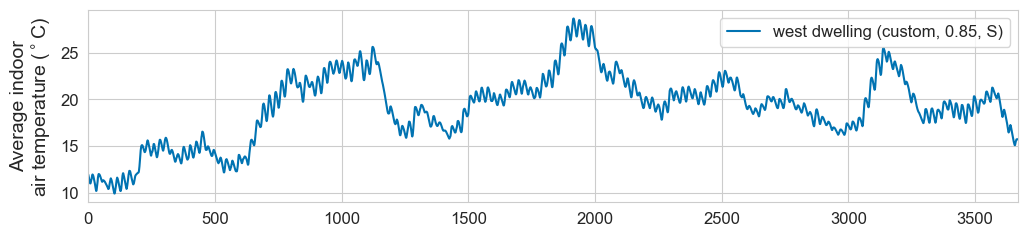

In [474]:
fig, ax = plt.subplots(figsize=figsize)
combined_results.plot(ax=ax)
ax.margins(0, None)
ax.set_ylabel(schema.VisualisationSchema.IAT)

In [475]:
temp_result_simulation.index = input_data.index
temp_result_simulation.sum()

Average_indoor_air_temperature_(degreeC)     70530.309265
Outdoor_air_temperature_(degreeC)            57629.690000
Heating_output_(kW)                              0.000000
Solar_radiation(W/m2)                       317298.276181
Solar_gains_(kW)                              2916.985323
Occupancy_gains_(kW)                             0.000000
Appliances_gains_(kW)                            0.000000
Total_gains_(kW)                              2916.985323
Internal_heat_gains_(kW)                         0.000000
Heating_season_flag                              0.000000
Ventilation_losses_(kW)                          0.000000
dtype: float64

number of modelled cooling degree hours 484.4256239087056
number of measured cooling degree hours 489.441965225055
The error in cooling degree hours of the model compared to measured data is -1.02%.
The MAE of the model compared to measured data is 0.76 degreeC.


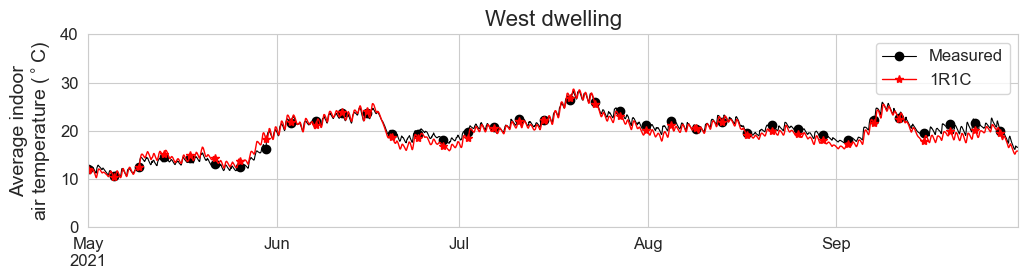

In [476]:
viz_results = validation.validation_RC_model(temp_result_simulation, parameters_dwelling_to_model)

fig, ax = plt.subplots(figsize=figsize)
fig, ax = viz_results.plot_results(fig, ax, plot_all_rooms=False)
ax.legend()
ax.set_xlabel("")
viz_results.calculate_metrics()
ax.set_title('West dwelling')

fig.savefig(path_save_figures/f"west_dwelling.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)
fig.savefig(path_save_figures/f"west_dwelling.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)

In [477]:
aaaa

NameError: name 'aaaa' is not defined

<AxesSubplot: xlabel='date'>

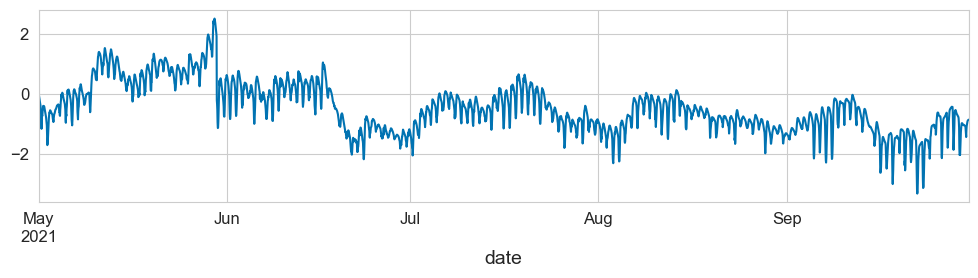

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
individual_rooms_IAT = validation.get_extended_measured_data(parameters_dwelling_to_model['filename'])
average_IAT = viz_results.weighted_average_measured_IAT_dwelling(individual_rooms_IAT)
viz_results.simulation_data[schema.DataSchema.IAT].sub(average_IAT.values.flatten()).plot(ax=ax)

In [ ]:
# for c in weather_data.columns:
#   fig, ax = plt.subplots(figsize=figsize)
#   ax.set_title(c)
#   weather_data.loc[individual_rooms_IAT.index, c].rolling(window=500).mean().plot(ax=ax)

In [ ]:
# ies_data = pd.read_excel(path_IES_data, sheet_name=sheet_name_IES, usecols=[x for x in range(2, 11)])
# ies_data = ies_data.iloc[:len(temp_result_simulation), :]
# ies_data.index = temp_result_simulation.index
# ies_data.head()

In [ ]:
### Visualisations

In [ ]:
temp_result_simulation.to_csv(Path(r"../data/results/temp_results_RC_model.csv"))
temp_result_simulation.head()

,Average_indoor_air_temperature_(degreeC),Outdoor_air_temperature_(degreeC),Heating_output_(kW),Solar_radiation(W/m2),Solar_gains_(kW),Occupancy_gains_(kW),Appliances_gains_(kW),Total_gains_(kW),Internal_heat_gains_(kW),Heating_season_flag,Ventilation_losses_(kW)
date,,,,,,,,,,,
2021-05-01 00:00:00+00:00,11.979518,5.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2021-05-01 01:00:00+00:00,11.847508,5.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2021-05-01 02:00:00+00:00,11.709501,5.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2021-05-01 03:00:00+00:00,11.569994,5.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2021-05-01 04:00:00+00:00,11.433393,4.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


<AxesSubplot: xlabel='Delta T', ylabel='Total_gains_(kW)'>

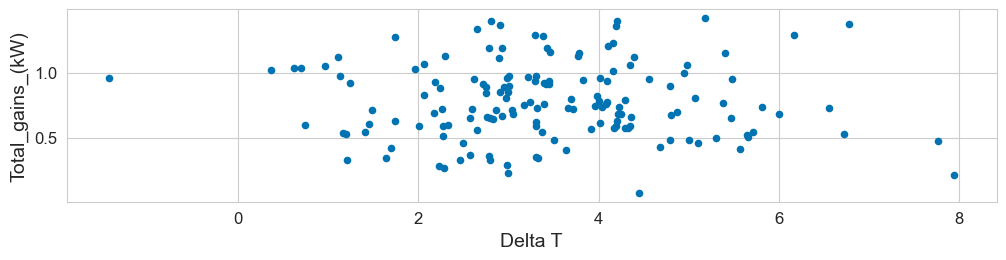

In [ ]:
daily_dataf = temp_result_simulation.copy()
daily_dataf.index = input_data.index
daily_dataf = daily_dataf.resample("1d").mean()
daily_dataf["Delta T"] = daily_dataf["Average_indoor_air_temperature_(degreeC)"] - daily_dataf["Outdoor_air_temperature_(degreeC)"]
fig, ax = plt.subplots(figsize=figsize)
daily_dataf.plot(ax=ax, kind="scatter", x="Delta T", y="Total_gains_(kW)")

<AxesSubplot: xlabel='date'>

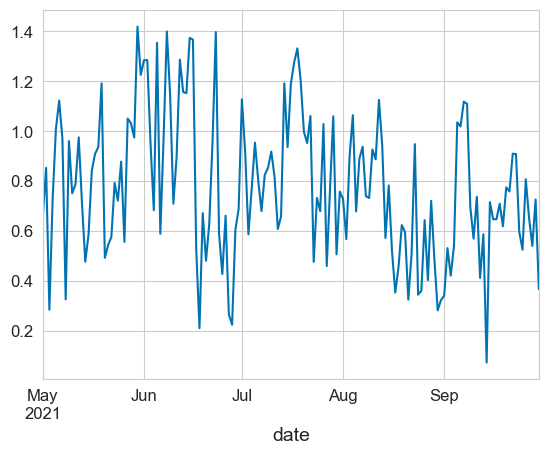

In [ ]:
daily_dataf["Total_gains_(kW)"].plot()

Text(0, 0.5, 'Heat gains (kW)')

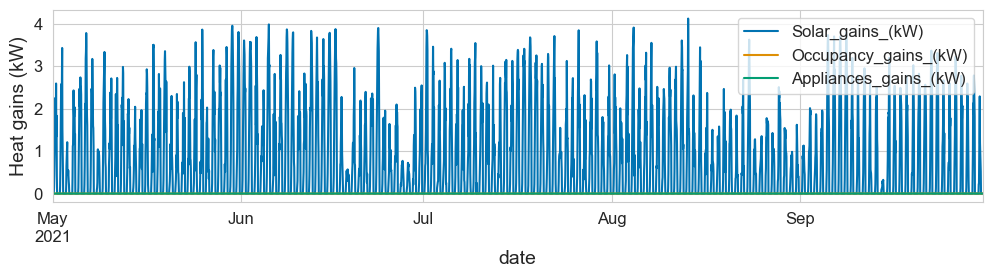

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
gains_cols = [schema.DataSchema.SOLARGAINS, schema.DataSchema.OCCUPANCYGAINS, schema.DataSchema.APPLIANCESGAINS]
temp_result_simulation[gains_cols].plot(ax=ax)
ax.margins(0, None)
ax.set_ylabel(schema.VisualisationSchema.GAINS)

In [ ]:
# fig, ax = plt.subplots(figsize=figsize)
# fig, ax = viz_results.plot_measured_data(fig, ax, plot_all_rooms=True)
# ax.get_legend_handles_labels()

In [ ]:
stop

NameError: name 'stop' is not defined

number of modelled cooling degree hours 158.29583434606627
number of measured cooling degree hours 489.441965225055
The error in cooling degree hours of the model compared to measured data is -67.66%.
The MAE of the model compared to measured data is 0.00 degreeC.


(-0.6765789499204901, 0.0)

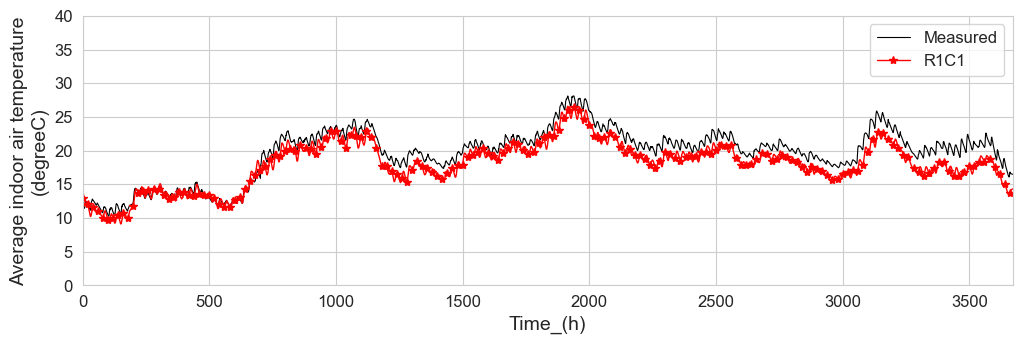

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
fig, ax = viz_results.plot_results(fig, ax, plot_all_rooms=False)
ax.legend()
viz_results.calculate_metrics()

max_cdh = 744.106575283237 and min_cdh = 744.106575283237


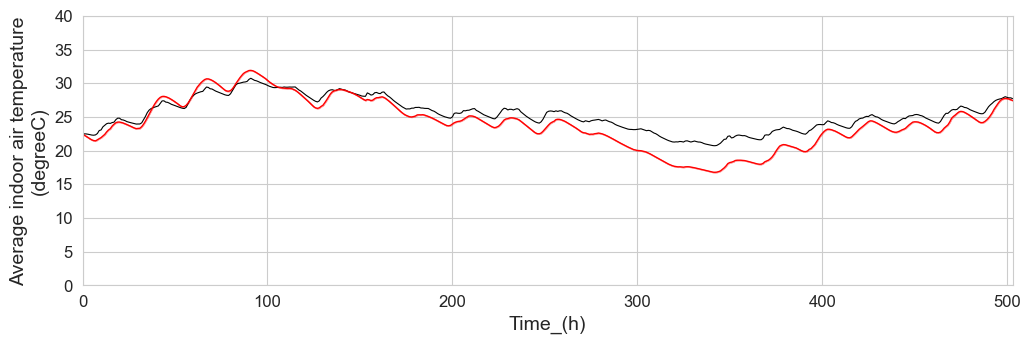

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
fig, ax = viz_results.plot_measured_data(fig, ax)
ax.legend().remove()

for c in combined_results.columns:
    combined_results[c].plot(ax=ax,
                            color='red',
                            linewidth=1)

upper_arrs = combined_results.max(axis=1)
lower_arrs = combined_results.min(axis=1)
x_arr = combined_results.index
ax.fill_between(x_arr, upper_arrs, lower_arrs, alpha=0.3, color='red')

max_cdh = validation.calculate_cooling_degree_hours(upper_arrs, 24)
min_cdh = validation.calculate_cooling_degree_hours(lower_arrs, 24)
print(f'max_cdh = {max_cdh} and min_cdh = {min_cdh}')

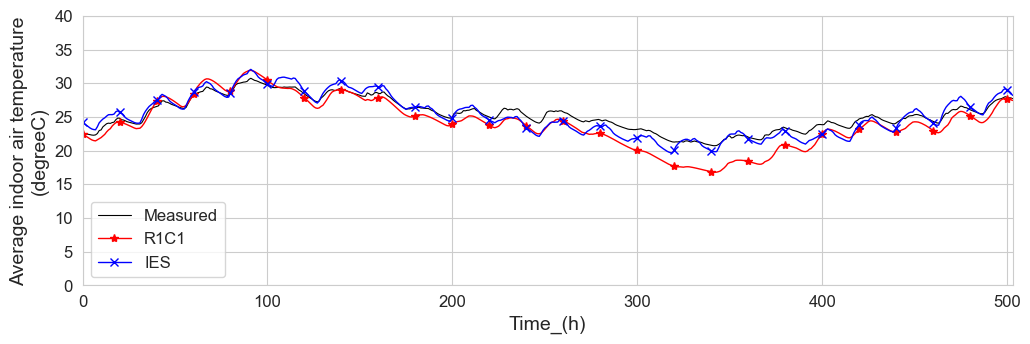

In [ ]:
ies_avg_iat = viz_results.weighted_average_measured_IAT_dwelling(ies_data[parameters_dwelling_to_model['sheet_names']])
ies_avg_iat.columns = [enums.DataSource.IES.value]
fig, ax = plt.subplots(figsize=figsize)
fig, ax = viz_results.plot_results(fig, ax)
ies_avg_iat.plot(
    ax=ax,
    kind='line',
    color='blue',
    marker='x',
    markevery=20,
    linewidth=1)
ax.legend()


In [ ]:
viz_results.calculate_metrics()
validation.calculate_cooling_degree_hours(ies_avg_iat[enums.DataSource.IES.value], 24)

number of modelled cooling degree hours 744.106575283237
number of measured cooling degree hours 916.9008929470098
The error in cooling degree hours of the model compared to measured data is -18.85%.
The MAE of the model compared to measured data is 1.52 degreeC.


986.724292490119

NameError: name 'dataf' is not defined

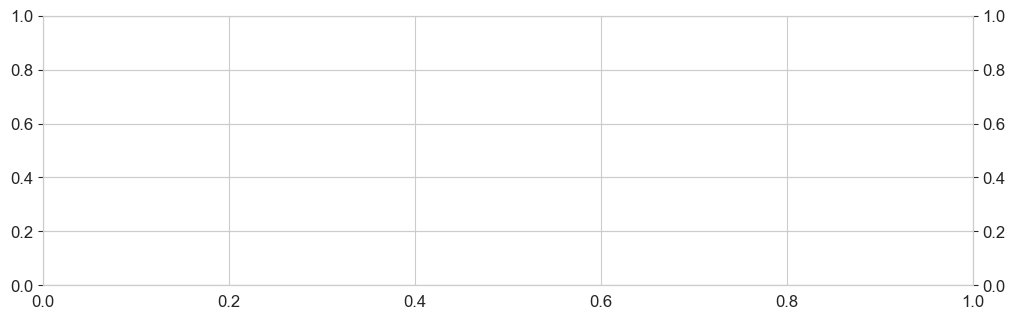

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
dataf[schema.OutputDataSchema.SOLARRADIATION].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.OutputDataSchema.SOLARRADIATION, color=sns.color_palette()[1])
dataf[schema.OutputDataSchema.OAT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.OutputDataSchema.OAT, color=sns.color_palette()[0])

ax2.grid(False)
ax.legend().remove()
ax.margins(0, None)

Text(0, 0.5, 'Heating_season_flag')

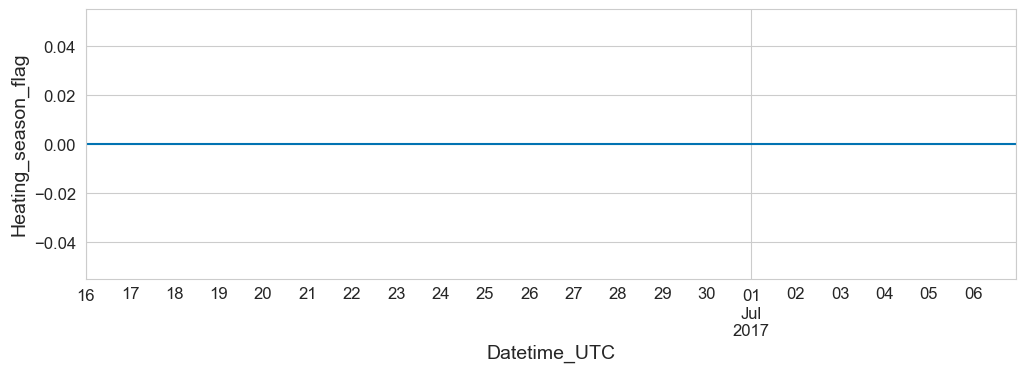

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
dataf[schema.OutputDataSchema.HEATINGSEASON].plot(ax=ax)
ax.set_ylabel(schema.OutputDataSchema.HEATINGSEASON)

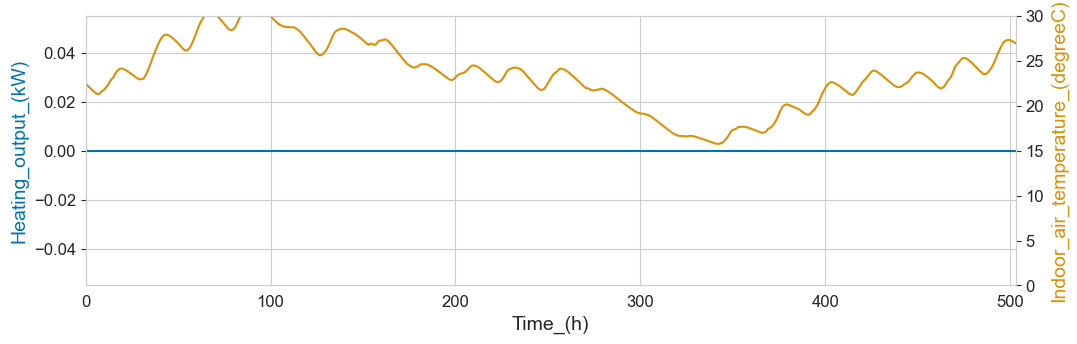

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
resampled_rcmodel_dataf[schema.DataSchema.HEATINGOUTPUT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.DataSchema.HEATINGOUTPUT, color=sns.color_palette()[0])
resampled_rcmodel_dataf[schema.DataSchema.IAT].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.DataSchema.IAT, color=sns.color_palette()[1])
ax2.set_ylim(0, 30)
ax2.grid(False)
ax.margins(0, None)

In [ ]:
resampled_rcmodel_dataf.head()

,Indoor_air_temperature_(degreeC),Outdoor_air_temperature_(degreeC),Heating_output_(kW),Solar_radiation(W/m2),Solar_gains_(kW),Heating_season_flag
Time_(h),,,,,,
0.0,22.467323,14.011765,0.0,1.340000,0.008073,0.0
1.0,22.268363,13.548149,0.0,1.226667,0.007390,0.0
2.0,22.070754,13.407579,0.0,1.296667,0.007812,0.0
3.0,21.863602,12.782423,0.0,1.346667,0.008113,0.0
4.0,21.654481,12.384498,0.0,5.033333,0.030323,0.0


The MAE of the model compared to measured data is 2.07 degreeC.
number of modelled cooling degree hours 629.5431865792941
number of measured cooling degree hours 916.9008929470098
The error in cooling degree hours of the model compared to measured data is -31.34%.


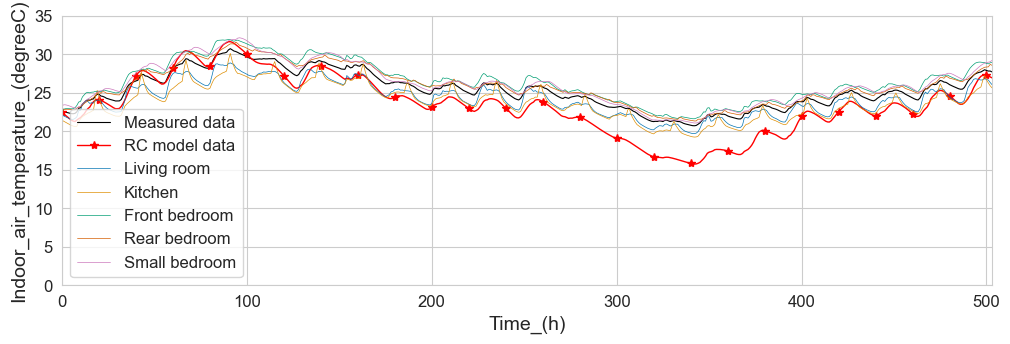

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

measured_IAT[schema.DataSchema.IAT].plot(ax=ax, color='black', linewidth=0.8)
resampled_rcmodel_dataf[schema.DataSchema.IAT].plot(ax=ax, color='red', marker='*', markevery=20, linewidth=1)

for ii, room in enumerate(individual_rooms_IAT.columns):
  individual_rooms_IAT[room].plot(ax=ax, color=sns.color_palette()[ii], linewidth=0.5)
list_rooms = ["Living room", "Kitchen", "Front bedroom", "Rear bedroom", "Small bedroom"]

ax.set_ylabel(schema.DataSchema.IAT)

ax.set_ylim(0, 35)

# ax.grid(False)
ax.margins(0, None)
handles, labels = ax.get_legend_handles_labels()
labels = ["Measured data", "RC model data"] + list_rooms
ax.legend(handles=handles, labels=labels)

MAE_results = functions.calculate_MAE(measured_IAT[schema.DataSchema.IAT], resampled_rcmodel_dataf[schema.DataSchema.IAT])
print(f"The MAE of the model compared to measured data is {MAE_results:.2f} degreeC.")

modelled_cooling_degree_hours = calculate_cooling_degree_hours(resampled_rcmodel_dataf[schema.DataSchema.IAT], 24)
measured_cooling_degree_hours = calculate_cooling_degree_hours(measured_IAT[schema.DataSchema.IAT], 24)
error_cooling_degree_hours = (modelled_cooling_degree_hours-measured_cooling_degree_hours)/measured_cooling_degree_hours
print(f'number of modelled cooling degree hours {modelled_cooling_degree_hours}')
print(f'number of measured cooling degree hours {measured_cooling_degree_hours}')
print(f"The error in cooling degree hours of the model compared to measured data is {error_cooling_degree_hours:.2%}.")

In [ ]:
fhfgfh



NameError: name 'fhfgfh' is not defined

In [ ]:
# Parameters 
path_results:Path = Path().absolute().parent/"data"
target_area:enums.Area = enums.Area.CARDIFF
target_year:int = 2020
CDD_ref_temperature:float = 24
solar_gains = True
timestep:int = 3600

# Dwelling parameters
R_dwelling = 1/0.2 #K/kW
C_dwelling = 20_000 #kJ/K
floor_area = 50 #m2
initial_indoor_air_temperature = 21

In [ ]:
# Load outdoor air temperature data for Cardiff
input_data = pd.read_csv(path_results/"raw"/f"{target_area.value}_degree_days.csv", index_col=0, parse_dates=True)
input_data

,Solar_radiation_(W/m2),Temperature_(degreeC),hdd_15.5,cdd_24.0
Datetime_UTC,,,,
2010-01-01 00:00:00+00:00,0.00000,-0.761292,0.677554,0.0
2010-01-01 01:00:00+00:00,0.00000,-1.053894,0.689746,0.0
2010-01-01 02:00:00+00:00,0.00000,-1.288513,0.699521,0.0
2010-01-01 03:00:00+00:00,0.00000,-1.463013,0.706792,0.0
2010-01-01 04:00:00+00:00,0.00000,-1.604095,0.712671,0.0
...,...,...,...,...
2022-07-31 20:00:00+00:00,17.05125,19.231354,0.000000,0.0
2022-07-31 21:00:00+00:00,0.00000,18.669556,0.000000,0.0
2022-07-31 22:00:00+00:00,0.00000,18.107727,0.000000,0.0


In [ ]:
# Load outdoor air temperature data for Cardiff
input_data = pd.read_csv(path_results/"raw"/f"{target_area.value}_degree_days.csv", index_col=0, parse_dates=True)

# Create models
dwelling = thermal_model.ThermalModel(R=R_dwelling, C=C_dwelling, initial_indoor_air_temperature=initial_indoor_air_temperature)
data_source = source.SimulationData(dwelling, input_data, timestep_simulation=3600)

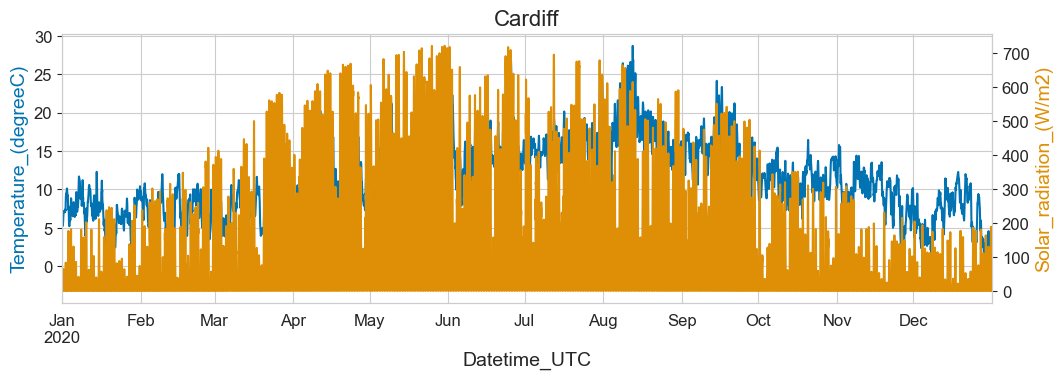

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
dataf = data_source.filter_era5_data(list_years=[target_year])
ax2 = ax.twinx()
dataf[schema.OutputDataSchema.SOLARRADIATION].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.OutputDataSchema.SOLARRADIATION, color=sns.color_palette()[1])
dataf[schema.OutputDataSchema.OAT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.OutputDataSchema.OAT, color=sns.color_palette()[0])

ax2.grid(False)
ax.set_title(f"{target_area.value}")
ax.legend().remove()
ax.margins(0, None)

Text(0, 0.5, 'Heating_season_flag')

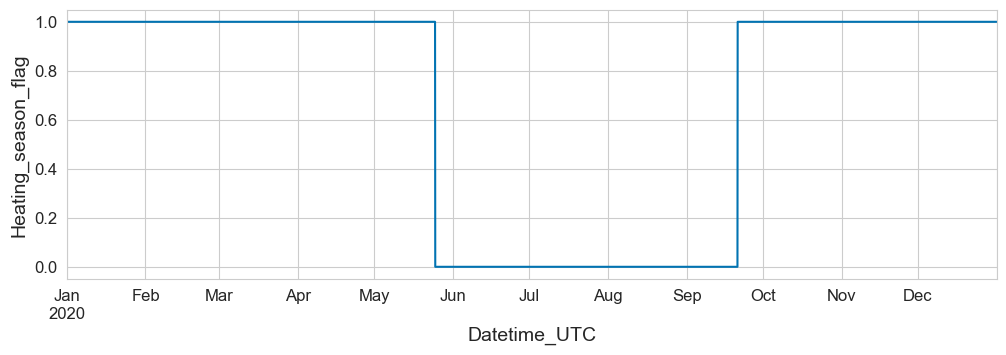

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
dataf[schema.OutputDataSchema.HEATINGSEASON].plot(ax=ax)
ax.set_ylabel(schema.OutputDataSchema.HEATINGSEASON)

In [ ]:
rcmodel_dataf=data_source.create_era5_based_simulation_data(estimate_solar_gains=solar_gains, list_years=[target_year])
rcmodel_dataf = dwelling.estimate_heating_demand(rcmodel_dataf)
resampled_rcmodel_dataf = data_source.resample_modelling_results(rcmodel_dataf)
functions.print_heating_and_cooling_demand(resampled_rcmodel_dataf)

heating demand 0.0kWh and cooling demand is 0.0kWh


(0.0, 0.0)

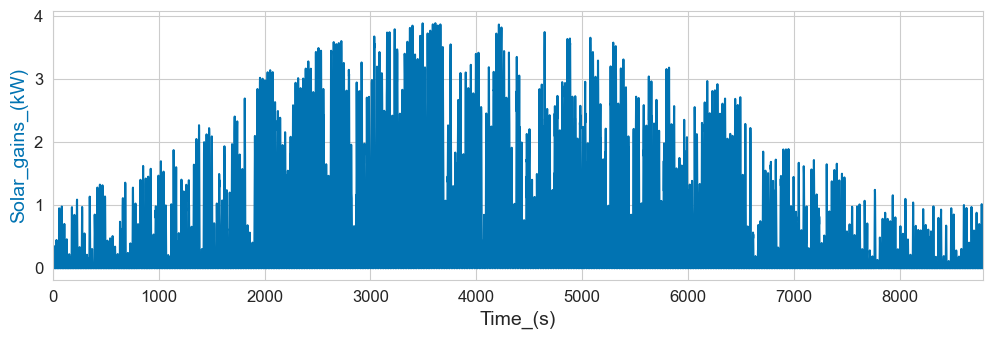

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
resampled_rcmodel_dataf[schema.DataSchema.SOLARGAINS].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.DataSchema.SOLARGAINS, color=sns.color_palette()[0])
ax.margins(0, None)

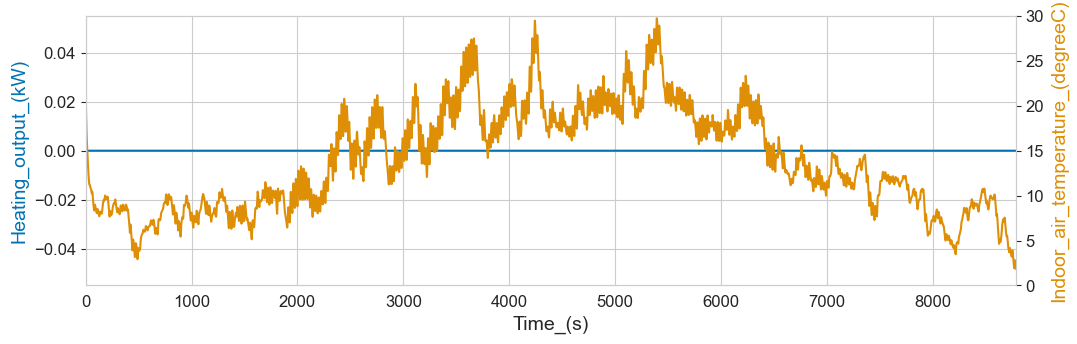

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
resampled_rcmodel_dataf[schema.DataSchema.HEATINGOUTPUT].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.DataSchema.HEATINGOUTPUT, color=sns.color_palette()[0])
resampled_rcmodel_dataf[schema.DataSchema.IAT].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.DataSchema.IAT, color=sns.color_palette()[1])
ax2.set_ylim(0, 30)
ax2.grid(False)
ax.margins(0, None)

In [ ]:
resampled_rcmodel_dataf.index= dataf.index
resampled_rcmodel_dataf.to_csv(r"../data/demo_dwelling_results/simulation_results.csv")

In [ ]:

functions.add_time_features(resampled_rcmodel_dataf)

resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON] = dataf[schema.OutputDataSchema.HEATINGSEASON] 
resampled_rcmodel_dataf[schema.OutputDataSchema.SOLARRADIATION] = dataf[schema.OutputDataSchema.SOLARRADIATION] 

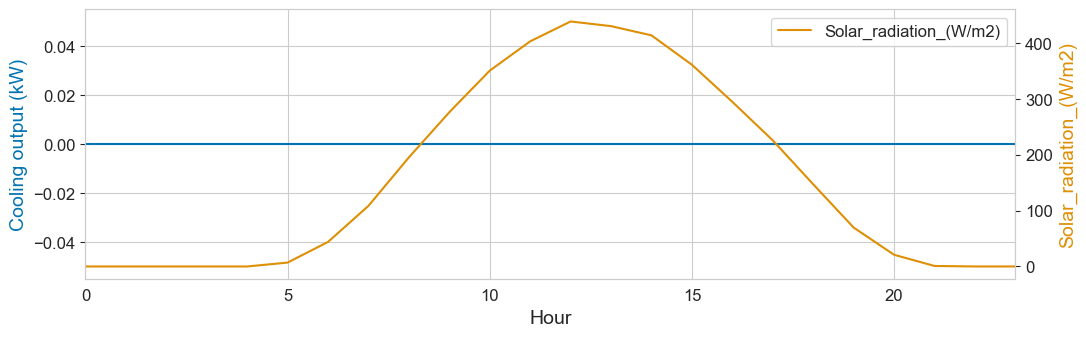

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
filt = (resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON]==0)

(resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.OutputDataSchema.SOLARRADIATION:"mean"})).plot(ax=ax2, color=sns.color_palette()[1])
(-resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.HEATINGOUTPUT:"mean"})).plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel("Cooling output (kW)", color=sns.color_palette()[0])
ax.legend().remove()
ax2.set_ylabel(schema.OutputDataSchema.SOLARRADIATION, color=sns.color_palette()[1])
ax2.grid(False)
ax.margins(0, None)

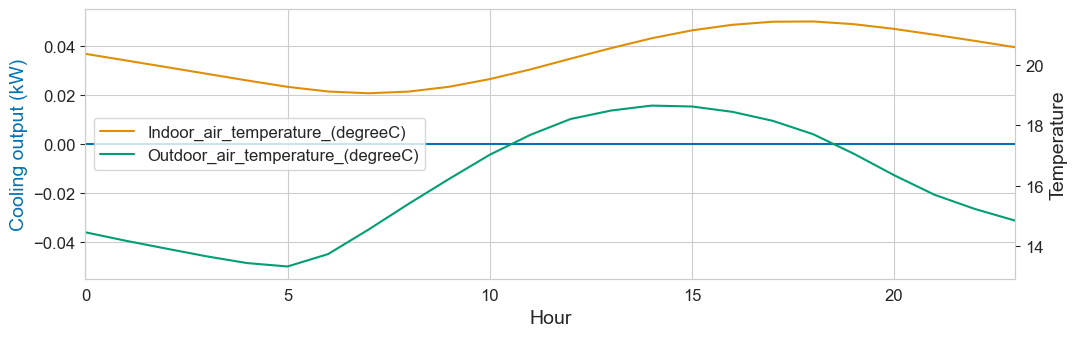

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
filt = (resampled_rcmodel_dataf[schema.OutputDataSchema.HEATINGSEASON]==0)

resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.IAT:"mean"}).plot(ax=ax2, color=sns.color_palette()[1])
resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.OAT:"mean"}).plot(ax=ax2, color=sns.color_palette()[2])
(-resampled_rcmodel_dataf.loc[filt].groupby("Hour").agg({schema.DataSchema.HEATINGOUTPUT:"mean"})).plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel("Cooling output (kW)", color=sns.color_palette()[0])
ax.legend().remove()
ax2.set_ylabel("Temperature")
ax2.grid(False)
ax.margins(0, None)



In [ ]:
resampled_rcmodel_dataf

,Indoor_air_temperature_(degreeC),Outdoor_air_temperature_(degreeC),Heating_output_(kW),Solar_radiation(W/m2),Solar_gains_(kW),Heating_season_flag,Hour,Day_of_week,Day,Month,Year,Weekday_flag,HH,Date,Week,Solar_radiation_(W/m2)
Datetime_UTC,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,21.000000,6.219452,0.0,0.0,0.0,1,0,2,1,1,2020,1,0,2020-01-01,1,0.0
2020-01-01 01:00:00+00:00,20.474867,6.148834,0.0,0.0,0.0,1,1,2,1,1,2020,1,2,2020-01-01,1,0.0
2020-01-01 02:00:00+00:00,19.962481,5.984192,0.0,0.0,0.0,1,2,2,1,1,2020,1,4,2020-01-01,1,0.0
2020-01-01 03:00:00+00:00,19.466904,5.947174,0.0,0.0,0.0,1,3,2,1,1,2020,1,6,2020-01-01,1,0.0
2020-01-01 04:00:00+00:00,18.986146,5.870697,0.0,0.0,0.0,1,4,2,1,1,2020,1,8,2020-01-01,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00+00:00,2.581136,-1.605987,0.0,0.0,0.0,1,19,3,366,12,2020,1,38,2020-12-31,53,0.0
2020-12-31 20:00:00+00:00,2.402370,-2.474487,0.0,0.0,0.0,1,20,3,366,12,2020,1,40,2020-12-31,53,0.0
2020-12-31 21:00:00+00:00,2.215388,-2.885620,0.0,0.0,0.0,1,21,3,366,12,2020,1,42,2020-12-31,53,0.0


In [ ]:
dataf

,Solar_radiation_(W/m2),Temperature_(degreeC),hdd_15.5,cdd_24.0,Heating_season_flag
Datetime_UTC,,,,,
2020-01-01 00:00:00+00:00,0.0,6.219452,0.386690,0.0,1
2020-01-01 01:00:00+00:00,0.0,6.148834,0.389632,0.0,1
2020-01-01 02:00:00+00:00,0.0,5.984192,0.396492,0.0,1
2020-01-01 03:00:00+00:00,0.0,5.947174,0.398034,0.0,1
2020-01-01 04:00:00+00:00,0.0,5.870697,0.401221,0.0,1
...,...,...,...,...,...
2020-12-31 19:00:00+00:00,0.0,-1.605987,0.712749,0.0,1
2020-12-31 20:00:00+00:00,0.0,-2.474487,0.748937,0.0,1
2020-12-31 21:00:00+00:00,0.0,-2.885620,0.766068,0.0,1


In [ ]:
results_dict = {}
heating_demand_dict = {}
for year in data_source.all_years[5:]:
    print(year)
    rcmodel_dataf=data_source.create_era5_based_simulation_data(estimate_solar_gains=solar_gains,list_years=[year])
    rcmodel_dataf = dwelling.estimate_heating_demand(rcmodel_dataf)
    resampled_rcmodel_dataf = data_source.resample_modelling_results(rcmodel_dataf)
    heating_demand, cooling_demand = functions.print_heating_and_cooling_demand(resampled_rcmodel_dataf)
    results_dict[year] = (heating_demand, cooling_demand)
    heating_demand_dict[year] = resampled_rcmodel_dataf.loc[:5088, schema.DataSchema.HEATINGOUTPUT].values
results_df = pd.DataFrame(results_dict, index=[schema.ResultSchema.HEATINGDEMAND, schema.ResultSchema.COOLINGDEMAND])
results_df.columns.names = [schema.ResultSchema.YEAR]

2015
heating demand 0.0kWh and cooling demand is 0.0kWh
2016
heating demand 0.0kWh and cooling demand is 0.0kWh
2017
heating demand 0.0kWh and cooling demand is 0.0kWh
2018
heating demand 0.0kWh and cooling demand is 0.0kWh
2019
heating demand 0.0kWh and cooling demand is 0.0kWh
2020
heating demand 0.0kWh and cooling demand is 0.0kWh
2021
heating demand 0.0kWh and cooling demand is 0.0kWh
2022
heating demand 0.0kWh and cooling demand is 0.0kWh


In [ ]:
profiles_df = pd.DataFrame.from_dict(heating_demand_dict)


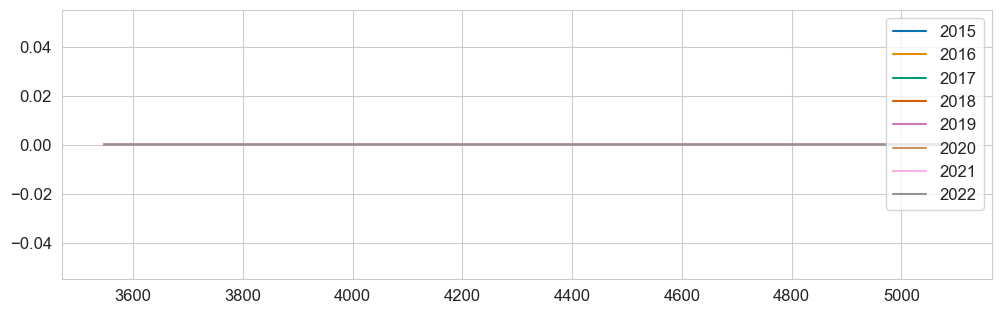

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
for c in profiles_df.columns:

    profiles_df.loc[3500:, c].rolling(window=48).mean().plot(ax=ax)

ax.legend()

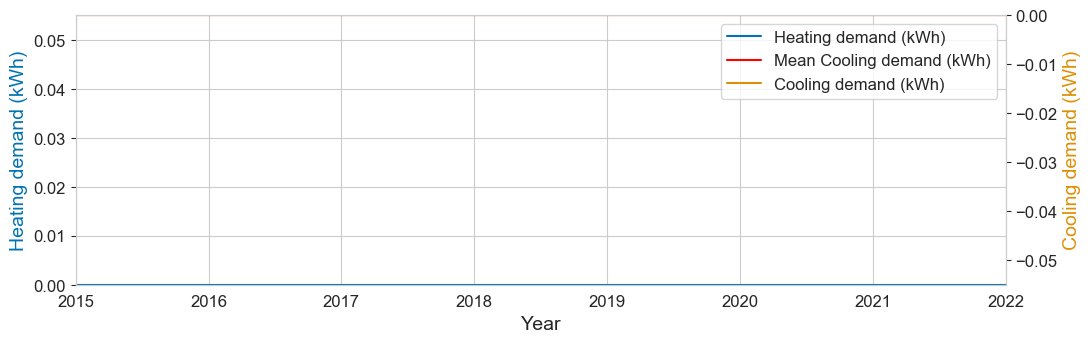

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax2 = ax.twinx()
results_df.T[schema.ResultSchema.HEATINGDEMAND].plot(ax=ax, color=sns.color_palette()[0])
ax.set_ylabel(schema.ResultSchema.HEATINGDEMAND, color=sns.color_palette()[0])


x_arr = results_df.columns
y_mean = [results_df.T[schema.ResultSchema.COOLINGDEMAND].mean()]*len(x_arr)
ax2.plot(x_arr, y_mean, label=f"Mean {schema.ResultSchema.COOLINGDEMAND}", color='red')
results_df.T[schema.ResultSchema.COOLINGDEMAND].plot(ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel(schema.ResultSchema.COOLINGDEMAND, color=sns.color_palette()[1])
ax2.set_ylim(None, 0)
ax.set_ylim(0, None)
ax2.grid(False)
ax.margins(0, None)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)